In [ ]:
#| hide

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# Simple Exponential Smoothing Optimized Model

> Step-by-step guide on using the `SimpleExponentialSmoothingOptimized Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

## Table of Contents

* [Introduction](#introduction)
* [Simple Exponential Smoothing Optimized Model](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of SimpleExponentialSmoothingOptimized with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>

Simple Exponential Smoothing Optimized (SES Optimized) is a forecasting model used to predict future values in univariate time series. It is a variant of the simple exponential smoothing (SES) method that uses an optimization approach to estimate the model parameters more accurately.

The SES Optimized method uses a single smoothing parameter to estimate the trend and seasonality in the time series data. The model attempts to minimize the mean squared error (MSE) between the predictions and the actual values in the training sample using an optimization algorithm. 

The SES Optimized approach is especially useful for time series with strong trend and seasonality patterns, or for time series with noisy data. However, it is important to note that this model assumes that the time series is stationary and that the variation in the data is random and there are no non-random patterns in the data. If these assumptions are not met, the SES Optimized model may not perform well and another forecasting method may be required.

## Simple Exponential Smoothing Model <a class="anchor" id="model"></a>

The simplest of the exponentially smoothing methods is naturally called simple exponential smoothing (SES). This method is suitable for forecasting data with no clear trend or seasonal pattern.

Using the naïve method, all forecasts for the future are equal to the last observed value of the series,
$$\hat{y}_{T+h|T} = y_{T},$$

for $h=1,2,\dots $. Hence, the naïve method assumes that the most recent observation is the only important one, and all previous observations provide no information for the future. This can be thought of as a weighted average where all of the weight is given to the last observation.

Using the average method, all future forecasts are equal to a simple average of the observed data,
$$\hat{y}_{T+h|T} = \frac1T \sum_{t=1}^T y_t, $$

for $h=1,2,\dots $ Hence, the average method assumes that all observations are of equal importance, and gives them equal weights when generating forecasts.

We often want something between these two extremes. For example, it may be sensible to attach larger weights to more recent observations than to observations from the distant past. This is exactly the concept behind simple exponential smoothing. Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations come from further in the past — the smallest weights are associated with the oldest observations:

\begin{equation}
  \hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots,   \tag{1}
\end{equation}

where $0 \le \alpha \le 1$ is the smoothing parameter. The one-step-ahead forecast for time $T+1$ is a weighted average of all of the observations in the series $y_1,\dots,y_T$. The rate at which the weights decrease is controlled by the parameter $\alpha$.

For any $\alpha$ between 0 and 1, the weights attached to the observations decrease exponentially as we go back in time, hence the name “exponential smoothing”. If $\alpha$ is small (i.e., close to 0), more weight is given to observations from the more distant past. If $\alpha$ is large (i.e., close to 1), more weight is given to the more recent observations. For the extreme case where $\alpha=1$, $\hat{y}_{T+1|T}=y_T$ and the forecasts are equal to the naïve forecasts.


## Optimisation

The application of every exponential smoothing method requires the smoothing parameters and the initial values to be chosen. In particular, for simple exponential smoothing, we need to select the values of $\alpha$ and $\ell_0$
 . All forecasts can be computed from the data once we know those values. For the methods that follow there is usually more than one smoothing parameter and more than one initial component to be chosen.

 In some cases, the smoothing parameters may be chosen in a subjective manner — the forecaster specifies the value of the smoothing parameters based on previous experience. However, a more reliable and objective way to obtain values for the unknown parameters is to estimate them from the observed data.

 From regression models we estimated the coefficients of a regression model by minimising the sum of the squared residuals (usually known as SSE or “sum of squared errors”). Similarly, the unknown parameters and the initial values for any exponential smoothing method can be estimated by minimising the SSE. The residuals are specified as $e_t=y_t - \hat{y}_{t|t-1}$ for $t=1,\dots,T$. Hence, we find the values of the unknown parameters and the initial values that minimise

\begin{equation}
\text{SSE}=\sum_{t=1}^T(y_t - \hat{y}_{t|t-1})^2=\sum_{t=1}^Te_t^2. \tag{2}
\end{equation}

Unlike the regression case (where we have formulas which return the values of the regression coefficients that minimise the SSE), this involves a non-linear minimisation problem, and we need to use an optimisation tool to solve it.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} Statsforecast will be needed. To install, see [instructions](../getting-started/Installation.ipynb). :::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

In [ ]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/ads.csv")
df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2017-09-13T00:00:00,80115,1
1,2017-09-13T01:00:00,79885,1
2,2017-09-13T02:00:00,89325,1
3,2017-09-13T03:00:00,101930,1
4,2017-09-13T04:00:00,121630,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

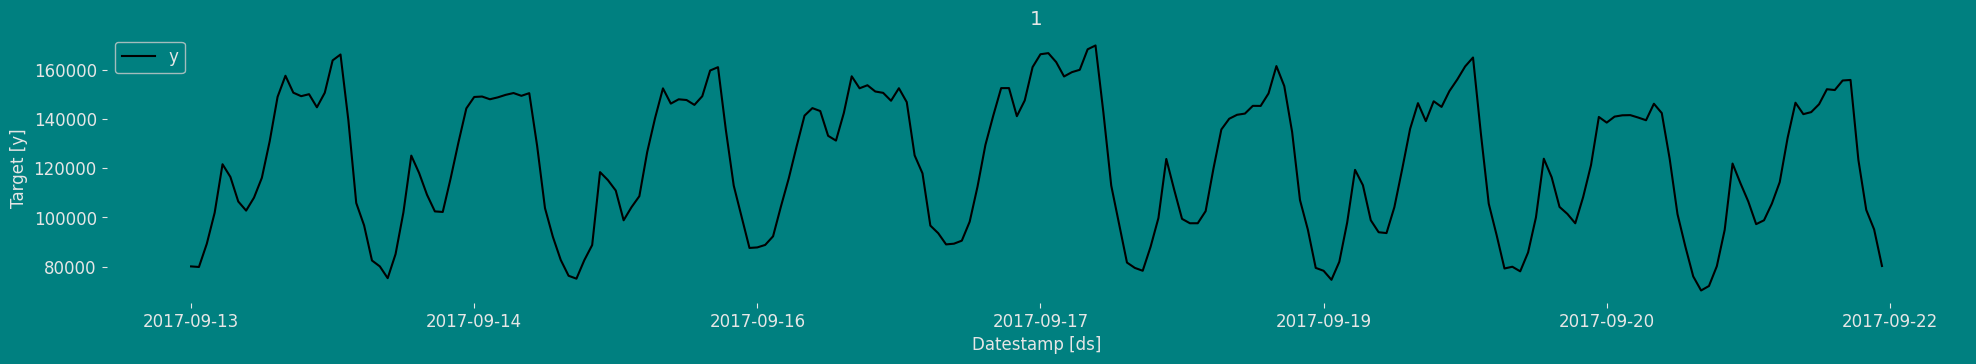

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### Autocorrelation plots

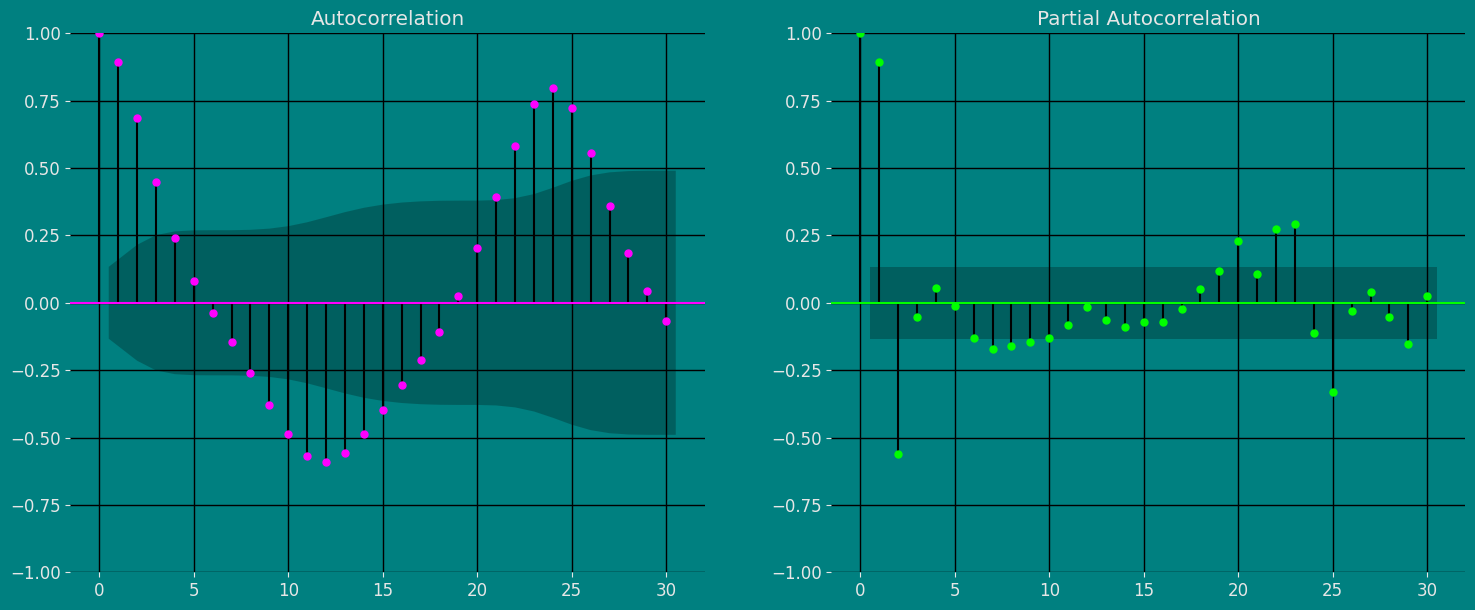

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets

1. Data to train our `Simple Exponential Smoothing Optimized Model`
2. Data to test our model

For the test data we will use the last 30 Hours to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2017-09-20 17:00:00'] 
test = df[df.ds>'2017-09-20 17:00:00'] 

In [ ]:
train.shape, test.shape

((186, 3), (30, 3))

Now let's plot the training data and the test data.

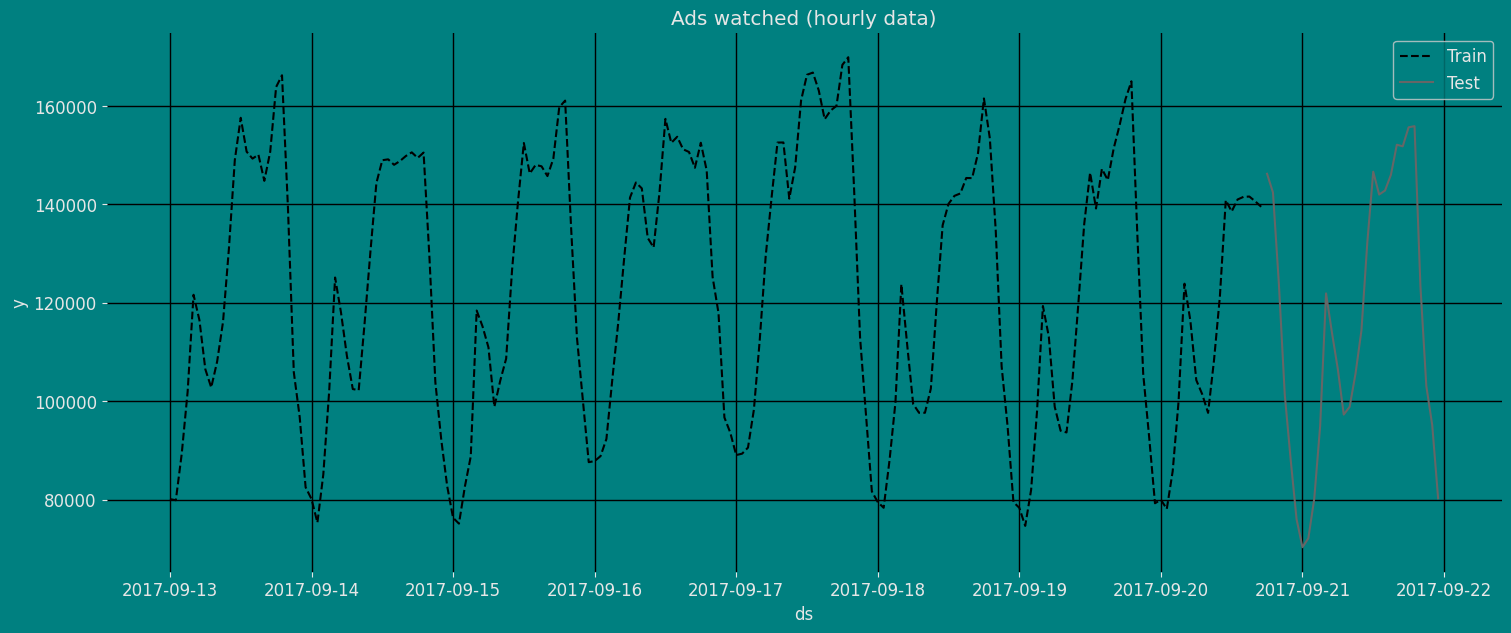

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.title("Ads watched (hourly data)");
plt.show()

## Implementation of SimpleExponentialSmoothingOptimized with StatsForecast <a class="anchor" id="implementation"></a>

To also know more about the parameters of the functions of the `SimpleExponentialSmoothingOptimized Model`, they are listed below. For more information, visit the [documentation](https://nixtla.github.io/statsforecast/src/core/models.html#simplesmooth).

```
alpha : float
    Smoothing parameter.
alias : str
    Custom name of the model.
prediction_intervals : Optional[ConformalIntervals]
    Information to compute conformal prediction intervals.
    By default, the model will compute the native prediction
    intervals.
```

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import SimpleExponentialSmoothingOptimized

### Instantiating Model

In [ ]:
horizon = len(test) # number of predictions

models = [SimpleExponentialSmoothingOptimized()] # multiplicative   additive

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(df=df,
                   models=models,
                   freq='H', 
                   n_jobs=-1)

### Fit the Model

In [ ]:
sf.fit()

StatsForecast(models=[SESOpt])

Let's see the results of our `Simple Exponential Smoothing Optimized model`. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

{'mean': array([80434.516], dtype=float32),
 'fitted': array([       nan,  80115.   ,  79887.3  ,  89230.625, 101803.01 ,
        121431.73 , 116524.57 , 106595.3  , 102833.   , 108002.78 ,
        116043.78 , 130880.14 , 148838.6  , 157502.48 , 150782.88 ,
        149309.88 , 150092.1  , 144833.12 , 150631.44 , 163707.92 ,
        166209.73 , 139786.89 , 106233.92 ,  96874.54 ,  82663.55 ,
         80150.38 ,  75383.16 ,  85007.78 , 101909.28 , 124902.74 ,
        118098.73 , 109313.734, 102543.39 , 102243.03 , 115704.03 ,
        130391.64 , 144185.67 , 148922.16 , 149147.72 , 148051.08 ,
        148802.4  , 149819.72 , 150562.5  , 149451.22 , 150509.31 ,
        129343.8  , 104070.29 ,  92293.95 ,  82860.29 ,  76380.45 ,
         75142.51 ,  82565.02 ,  88732.7  , 118133.02 , 115219.43 ,
        110982.8  ,  98981.23 , 104132.96 , 108619.68 , 126459.8  ,
        140295.25 , 152348.25 , 146335.73 , 148003.16 , 147737.69 ,
        145769.88 , 149249.84 , 159620.25 , 161070.36 , 135775

Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
fitted=pd.DataFrame(result.get("fitted"), columns=["fitted"])
fitted["ds"]=df["ds"]
fitted

,fitted,ds
0,NaN,2017-09-13 00:00:00
1,80115.000000,2017-09-13 01:00:00
2,79887.296875,2017-09-13 02:00:00
...,...,...
213,123719.921875,2017-09-21 21:00:00
214,103286.398438,2017-09-21 22:00:00
215,95236.312500,2017-09-21 23:00:00


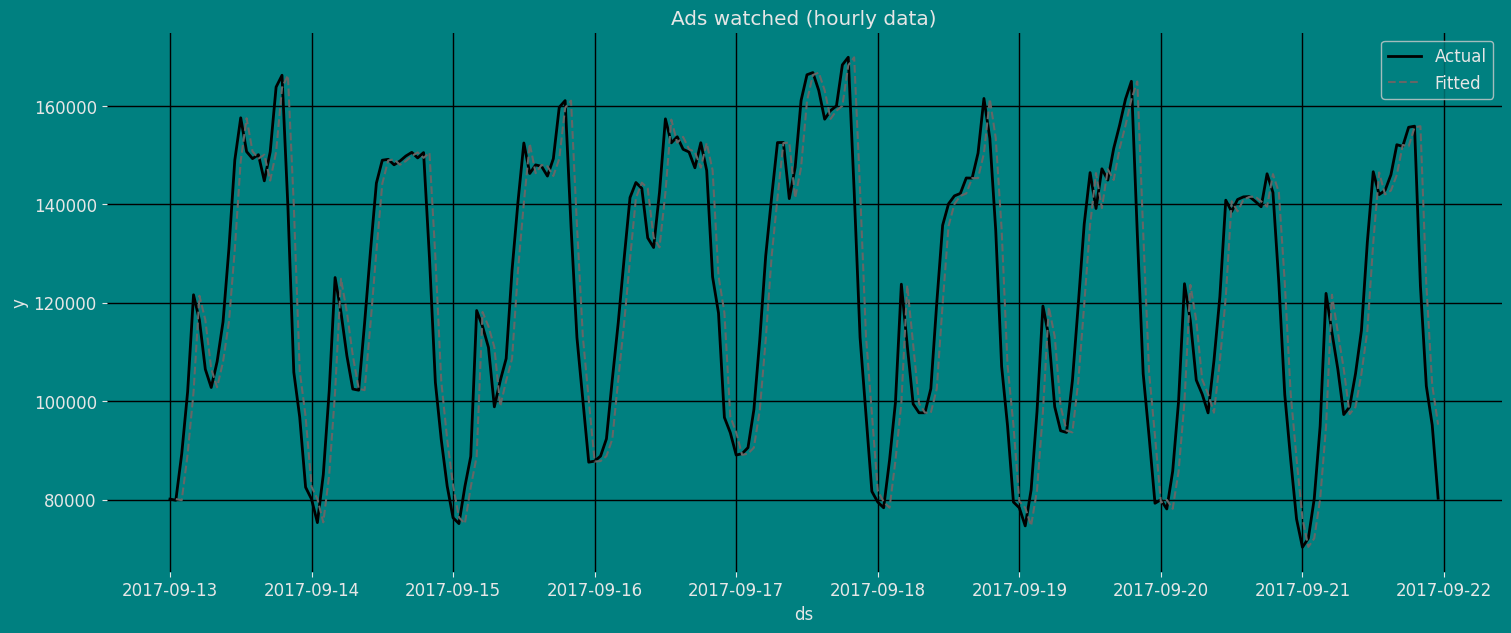

In [ ]:
sns.lineplot(df, x="ds", y="y", label="Actual", linewidth=2)
sns.lineplot(fitted,x="ds", y="fitted", label="Fitted", linestyle="--" )

plt.title("Ads watched (hourly data)");
plt.show()

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hors ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min.

In [ ]:
# Prediction
Y_hat = sf.forecast(horizon, fitted=True)

Y_hat

,ds,SESOpt
unique_id,,
1,2017-09-22 00:00:00,80434.515625
1,2017-09-22 01:00:00,80434.515625
1,2017-09-22 02:00:00,80434.515625
...,...,...
1,2017-09-23 03:00:00,80434.515625
1,2017-09-23 04:00:00,80434.515625
1,2017-09-23 05:00:00,80434.515625


Let's visualize the fitted values

In [ ]:
values=sf.forecast_fitted_values()
values.head()

,ds,y,SESOpt
unique_id,,,
1,2017-09-13 00:00:00,80115.0,NaN
1,2017-09-13 01:00:00,79885.0,80115.000000
1,2017-09-13 02:00:00,89325.0,79887.296875
1,2017-09-13 03:00:00,101930.0,89230.625000
1,2017-09-13 04:00:00,121630.0,101803.007812


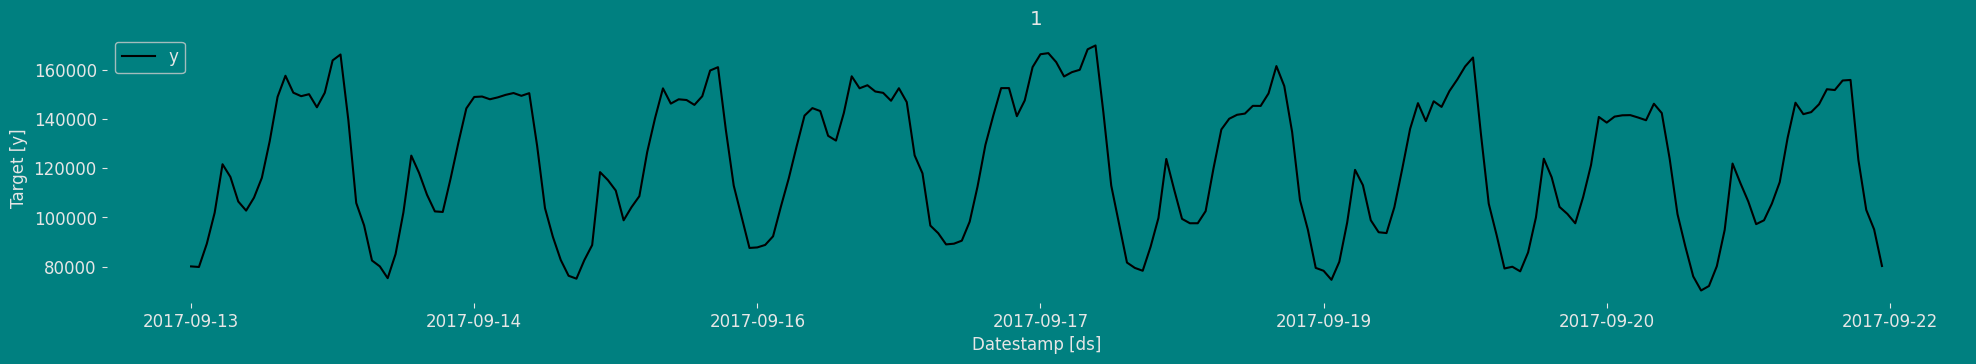

In [ ]:
StatsForecast.plot(values)

In [ ]:
sf.forecast(h=horizon)

,ds,SESOpt
unique_id,,
1,2017-09-22 00:00:00,80434.515625
1,2017-09-22 01:00:00,80434.515625
1,2017-09-22 02:00:00,80434.515625
...,...,...
1,2017-09-23 03:00:00,80434.515625
1,2017-09-23 04:00:00,80434.515625
1,2017-09-23 05:00:00,80434.515625


In [ ]:
Y_hat=Y_hat.reset_index()
Y_hat.head(10)

,unique_id,ds,SESOpt
0,1,2017-09-22 00:00:00,80434.515625
1,1,2017-09-22 01:00:00,80434.515625
2,1,2017-09-22 02:00:00,80434.515625
...,...,...,...
7,1,2017-09-22 07:00:00,80434.515625
8,1,2017-09-22 08:00:00,80434.515625
9,1,2017-09-22 09:00:00,80434.515625


### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 30 hours ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
forecast_df = sf.predict(h=horizon) 

forecast_df

,ds,SESOpt
unique_id,,
1,2017-09-22 00:00:00,80434.515625
1,2017-09-22 01:00:00,80434.515625
1,2017-09-22 02:00:00,80434.515625
...,...,...
1,2017-09-23 03:00:00,80434.515625
1,2017-09-23 04:00:00,80434.515625
1,2017-09-23 05:00:00,80434.515625


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [ ]:
df_plot=pd.concat([df, forecast_df]).set_index('ds')
df_plot

,y,unique_id,SESOpt
ds,,,
2017-09-13 00:00:00,80115.0,1.0,NaN
2017-09-13 01:00:00,79885.0,1.0,NaN
2017-09-13 02:00:00,89325.0,1.0,NaN
...,...,...,...
2017-09-23 03:00:00,NaN,NaN,80434.515625
2017-09-23 04:00:00,NaN,NaN,80434.515625
2017-09-23 05:00:00,NaN,NaN,80434.515625


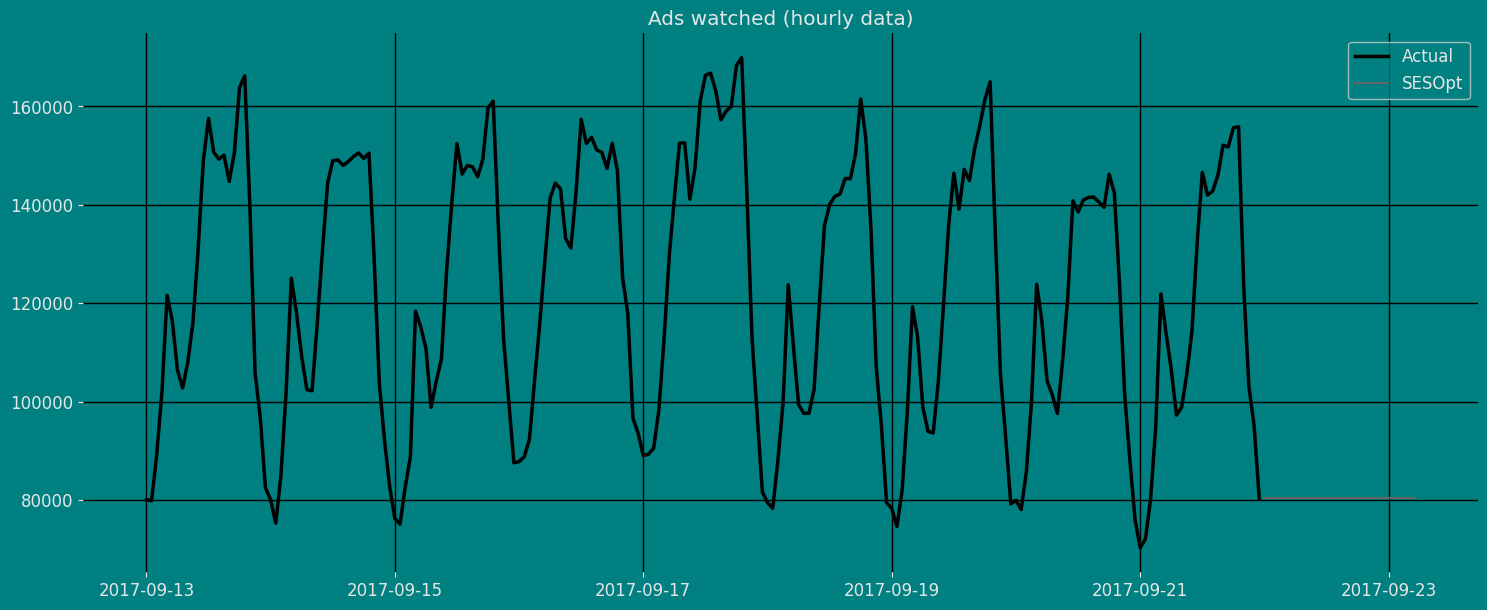

In [ ]:
# Plot the data and the exponentially smoothed data
plt.plot(df_plot['y'],label="Actual", linewidth=2.5)
plt.plot(df_plot['SESOpt'], label="SESOpt") # '-', '--', '-.', ':',
plt.title("Ads watched (hourly data)");
plt.ylabel("")
plt.legend()
plt.show()

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

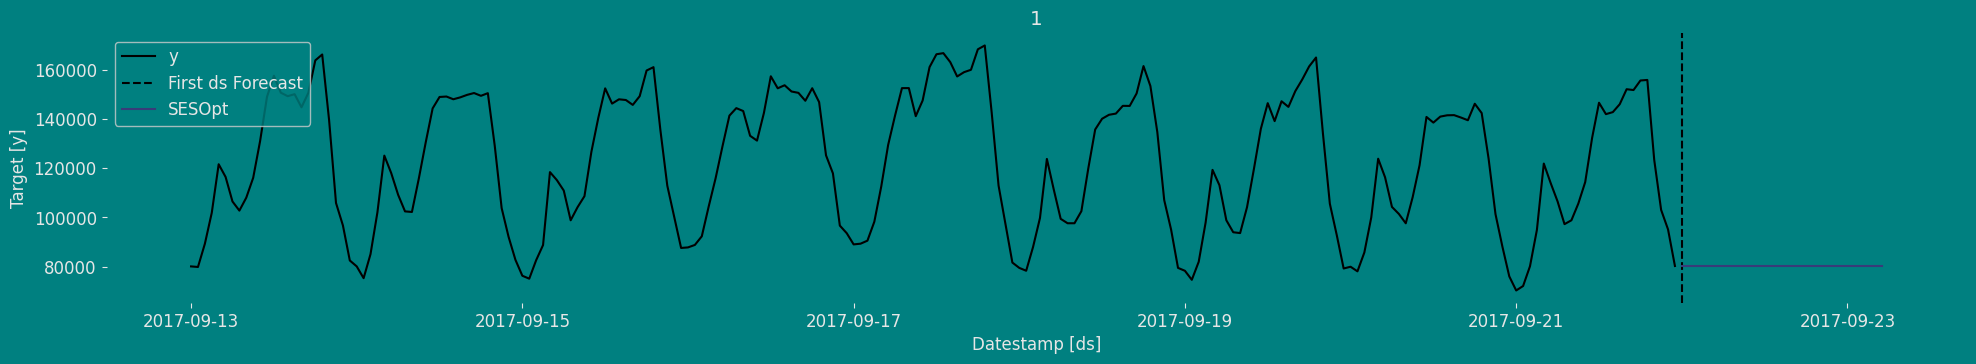

In [ ]:
sf.plot(df, forecast_df)

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation


Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 30 hours ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=df,
                                         h=horizon,
                                         step_size=30,
                                         n_windows=3)

The crossvaldation_df object is a new data frame that includes the following columns:

* `unique_id:` index. If you dont like working with index just run `crossvalidation_df.resetindex()`.
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `model:` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,ds,cutoff,y,SESOpt
unique_id,,,,
1,2017-09-18 06:00:00,2017-09-18 05:00:00,99440.0,111447.140625
1,2017-09-18 07:00:00,2017-09-18 05:00:00,97655.0,111447.140625
1,2017-09-18 08:00:00,2017-09-18 05:00:00,97655.0,111447.140625
...,...,...,...,...
1,2017-09-21 21:00:00,2017-09-20 17:00:00,103080.0,139526.046875
1,2017-09-21 22:00:00,2017-09-20 17:00:00,95155.0,139526.046875
1,2017-09-21 23:00:00,2017-09-20 17:00:00,80285.0,139526.046875


In [ ]:
cross_validation=crossvalidation_df.copy()
cross_validation.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values 

cutoff = cross_validation['cutoff'].unique()

for k in range(len(cutoff)): 
    cv = cross_validation[cross_validation['cutoff'] == cutoff[k]]
    StatsForecast.plot(df, cv.loc[:, cv.columns != 'cutoff'])

## Evaluate Model <a class="anchor" id="evaluate"></a>

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

In [ ]:
%%capture
!pip install datasetsforecast

In [ ]:
from datasetsforecast.losses import rmse

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, `Simple Exponential Smoothing Optimized Model`.

In [ ]:
rmse = rmse(cross_validation['actual'], cross_validation["SESOpt"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  30098.377


## References <a class="anchor" id="references"></a>

1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#arch-model).
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).